<a href="https://colab.research.google.com/github/lucasmtz/fair-face-recognition/blob/main/Face_Biometrics_Bias_in_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook takes around 16 minutes to execute completely using Google Colab Enviroment with a Tesla T4 GPU.

# Download and extract **DiveFace** database
https://github.com/BiDAlab/DiveFace


In [ ]:
import time
start = time.time()

In [ ]:
 %%time
# Download the database
!gdown --id 1kw5yFlxfo4H0960Hnu9h9QZwesWeF7S-
print('Extracting images...')
!unrar -idq x -o- 4K_120.rar
!rm 4K_120.rar
print('Done!')

Downloading...
From: https://drive.google.com/uc?id=1kw5yFlxfo4H0960Hnu9h9QZwesWeF7S-
To: /content/4K_120.rar
434MB [00:06, 63.6MB/s]
Extracting images...
Done!
CPU times: user 176 ms, sys: 46.5 ms, total: 222 ms
Wall time: 23.4 s


# Installing and importing libraries

---



In [ ]:
print('Installing and importing libraries...')
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

import os
import gc
import pickle
import sys
from glob import glob

import cv2
import keras_vggface
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_vggface import utils
from keras_vggface.vggface import VGGFace
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
import keras
from keras import backend as K
from keras import layers, models, optimizers, regularizers
from keras.layers import (Activation, ActivityRegularization,
                                     Conv2D, Dense, Dropout, Flatten, Input,
                                     Lambda, MaxPooling2D)
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

print('Done!')

Installing and importing libraries...
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-vq5t1xga
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-vq5t1xga
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=775bf44bfa1b30bde5deb98c8561a0c0cee5144521fdd2a4cb8016e65eafdb5d
  Stored in directory: /tmp/pip-ephem-wheel-cache-m8do6tpr/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 7.5MB/s 
Done!


# Check if GPU is running

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!nvidia-smi

Sun May 30 20:01:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Helper functions

## Select dataframe based on each demographic group


In [ ]:
# Helper function to select dataframe based on each demographic group
def make_dataset(
    df,
    gender=["H", "M"],
    ethnicity=["A", "B", "N"],
    img_per_subject=1,
    start=0,
    end=1000,
):
    print("Filtering Datasets...")
    print(f"----INFO:\n--Filtered genders: {gender}\n--Filtered ethnicities: {ethnicity}\n--Images per Subject: {img_per_subject}")
    print(f"--First img index for each group: {start}")
    print(f"--Last img index for each group: {end-1}")
    df = df.loc[
        df.demographic_group.str[0].isin(gender)
        & df.demographic_group.str[1].isin(ethnicity)
    ]
    df_X_img_subject = (
        df.groupby(["demographic_group", "identity"])
        .nth(list(range(img_per_subject)))
        .reset_index()
    )
    df_x1_x2_subjects_per_group = df_X_img_subject.groupby("demographic_group").apply(
        lambda gp: gp.iloc[start:end]
    ).reset_index(drop=True)
    print(f"--Total images: {df_x1_x2_subjects_per_group.shape[0]}")
    print(f"--Images per Demographic group:\n{df_x1_x2_subjects_per_group.demographic_group.value_counts()}")
    return df_x1_x2_subjects_per_group

## Read images from path using OpenCV

In [ ]:
def read_img(file_path, image_size=224):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
    return img

## Create arrays (imgs, labels) with loaded images and labels from input dataframe 


In [ ]:
def create_input(df, task="gender"):
    if task == "gender":
        df["gender"] = df["demographic_group"].str[0]
    elif task == "ethnicity":
        df["ethnicity"] = df["demographic_group"].str[1]
    else:
        task = "demographic_group"
    if task != "demographic_group":
        task_labels = sorted(set(df[task]))
        dict_encode = {v: i for i, v in enumerate(task_labels)}
        df.loc[:, task] = df.loc[:, task].map(dict_encode)
        # print("Taks labels:", task_labels)
        # print("dict_encode:", dict_encode)
    iterator = df.loc[:, ["path", task]].values
    imgs = []
    labels = []
    for (file_path, label) in iterator:
        img = read_img(file_path)
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0) 
        imgs.append(img)
        labels.append(label)

    imgs = np.concatenate(imgs, axis=0)
    labels = np.array(labels).reshape(-1)

    return imgs, labels

## Plot TNSE representation

In [ ]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data


def plot_representations(data, labels, n_images=None):
    le = preprocessing.LabelEncoder()
    colors = le.fit_transform(labels.ravel())
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=colors, cmap="Accent")
    handles, labels = scatter.legend_elements()
    labels = list(le.inverse_transform(list(set(colors))))
    legend = ax.legend(handles=handles, labels=labels)
    plt.show()

## Plot a grid figure with 5 images for each demographic group of the Dataframe

In [ ]:
def plot_5_sample(df):
    imgs = []
    dg_list = sorted(df.demographic_group.unique())
    for dg in dg_list:
        p = df.loc[df.demographic_group == dg, "path"].iloc[0:5]
        imgs_gp = []
        for im in p:
            img = read_img(im)
            imgs_gp.append(img)
        imgs.append(np.vstack(imgs_gp))
    stacked_imgs = np.hstack(imgs)
    fig, ax = plt.subplots(figsize=(5 * 4 // 2, 6 * 4 // 2))

    xticks = [stacked_imgs.shape[1]/12 + i*stacked_imgs.shape[1]/6 for i in range(6)]
    yticks = [stacked_imgs.shape[0]/10 + i*stacked_imgs.shape[0]/5 for i in range(5)]

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(dg_list)
    ax.yaxis.set_ticklabels([])
    plt.imshow(stacked_imgs)
    plt.title('Example images for each demographic group')
    plt.show()

## Create train, validation and test sets
Create numpy arrays with images and labels for each set based on number of train examples, gender and ethnicity classes and task

In [ ]:
def make_train_valid_test(
    df,
    n_train,
    gender=["H", "M"],
    ethnicity=["A", "B", "N"],
    task="gender",
):
    print("-----------------------------------------------------------------")
    print("Creating input data...")
    print("-----------------------------------------------------------------")
    n_train = n_train // (len(gender) * len(ethnicity))
    n_valid = n_train + n_train // 2
    n_test = n_valid + n_train // 2

    print("\n----------TRAIN----------\n")
    df_train = make_dataset(
        df, gender=gender, ethnicity=ethnicity, start=0, end=n_train
    )

    print("\n----------VALID----------\n")
    df_valid = make_dataset(
        df, gender=gender, ethnicity=ethnicity, start=n_train, end=n_valid
    )

    print("\n----------TEST----------\n")
    df_test = make_dataset(
        df, gender=gender, ethnicity=ethnicity, start=n_valid, end=n_test
    )
    print("\n########## DATA SUMMARY ##########\n")
    print("Genders:", gender)
    print("Ethnicities:", ethnicity)
    print("Task:", task)
    print(
        "df_train",
        df_train.shape,
        "\ndf_valid",
        df_valid.shape,
        "\ndf_test",
        df_test.shape,
    )

    X_train, y_train = create_input(df_train, task=task)
    X_valid, y_valid = create_input(df_valid, task=task)
    X_test, y_test = create_input(df_test, task=task)

    return X_train, y_train, X_valid, y_valid, X_test, y_test

## Create new model from base_model
Transfer learning: dense layer (1024 units Relu) + softmax output (n_outputs = task classes)

In [ ]:
def clone_model_and_wights(base_model):
    base_model_clone = keras.models.clone_model(base_model)
    base_model_clone.set_weights(base_model.get_weights())
    return base_model_clone

def create_model(n_outputs, base_model, feature_space_2D=False):
    K.clear_session()
    print("n_outputs:", n_outputs)
    # Clone the model and weights
    base_model_clone = clone_model_and_wights(base_model)
    base_model_clone.trainable = False
    # Select the last layer from base_model as feature embeddings
    feature_embeddings = base_model_clone.get_layer("flatten").output
    # Add a simple dense layer (relu) and a softmax output
    dense_layer = Dense(1024, name="dense_layer", activation="relu")(feature_embeddings)
    if feature_space_2D:
        feature_layer = Dense(2, activation='linear', name='feature_layer')(dense_layer)
        output_layer = Dense(n_outputs, name="output_layer", activation="softmax")(feature_layer)
    else:
        output_layer = Dense(n_outputs, name="output_layer", activation="softmax")(dense_layer)
    # Create the new model
    model = Model(base_model_clone.input, output_layer)
    # Compile the model
    loss="sparse_categorical_crossentropy"
    optimizer = keras.optimizers.SGD(learning_rate=0.05)    
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])

    return model

## Train and evaluate 

In [ ]:
def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
    plt.show()


def train(X_train, y_train, X_valid, y_valid, base_model, feature_space_2D=False):
    n_outputs = np.unique(y_train).shape[0]
    model = create_model(n_outputs, base_model, feature_space_2D)
    callback = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    print("\n-----------------------------------------------------------------")
    print("Training...")
    print("-----------------------------------------------------------------")
    print("X_train.shape", X_train.shape)
    print("y_train.shape", y_train.shape)
    print("\n")
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        validation_data=(X_valid,y_valid),
        callbacks=[callback],
        verbose=1,
    )
    plot_history(history)
    print(
        "Best epoch:",
        np.argmin(history.history["val_loss"]) + 1,
        "val_loss:",
        np.min((history.history["val_loss"])),
    )
    return model

def decoded_predictions(model, X_test, task_labels):
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    labels = np.array(sorted(set(task_labels)))
    return labels[y_pred]

def evaluate(model, X_test, y_test, task_labels=["H", "M"]):
    print("\n-----------------------------------------------------------------")
    print("Evaluating...")
    print("-----------------------------------------------------------------")
    print("Evaluation on test set:", model.evaluate(X_test, y_test))
    y_pred = np.argmax(model.predict(X_test), axis=-1)
    labels = np.array(sorted(set(task_labels)))
    y_test = labels[y_test]
    y_pred = labels[y_pred]

    print(classification_report(y_test, y_pred, labels=labels))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    disp = ConfusionMatrixDisplay(cm, labels)
    disp.plot(values_format='d')
    plt.show()

## Make and display GradCam 

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4, display_img=False):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    img_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap * alpha)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Display Grad CAM
    if display_img:
        display(superimposed_img)
    return superimposed_img, img_heatmap

## Plot GradCam stacked images

In [ ]:
def plot_grad_cam(model, conv_name, imgs, task_labels):
    n_imgs_gp = imgs.shape[0]//6
    labels = ['HA', 'HB', 'HN', 'MA', 'MB', 'MN']
    predictions = decoded_predictions(model, imgs, task_labels)
    # Clone model to keep the original one untouched
    cloned_model = clone_model_and_wights(model)
    # Remove last layer's softmax
    cloned_model.layers[-1].activation = None
    plt_imgs = []
    preds = []
    for dg, (img, pred) in enumerate(zip(imgs, predictions)):
        if not (dg % n_imgs_gp):
            heatmap_dg = []
            superimposed_dg = []
            dg_count = 0      
        img_array = np.expand_dims(img, axis=0)

        # Generate class activation heatmap #last_conv_layer_name
        heatmap = make_gradcam_heatmap(img_array, cloned_model, conv_name)

        # Display heatmap
        superimposed_img, img_heatmap = save_and_display_gradcam(img, heatmap)
        superimposed_img = keras.preprocessing.image.img_to_array(superimposed_img)
        img_heatmap = keras.preprocessing.image.img_to_array(img_heatmap)
        heatmap_dg.append(img_heatmap)
        dg_count += 1
        if dg_count < 6:
            superimposed_dg.append(superimposed_img)
            preds.append(pred)
        if dg_count == n_imgs_gp:
            heatmap_dg_mean = np.mean(heatmap_dg, axis=0)
            superimposed_dg.append(heatmap_dg_mean)
            plt_imgs.append(np.vstack(superimposed_dg))  
    stacked_imgs = np.hstack(plt_imgs)
    
    # Plot 
    fig, ax = plt.subplots(figsize=(6 * 4 // 2, 6 * 4 // 2))
    xticks = [stacked_imgs.shape[1]/12 + i*stacked_imgs.shape[1]/6 for i in range(6)]
    yticks = [stacked_imgs.shape[0]/12 + i*stacked_imgs.shape[0]/6 for i in range(6)]
    bbox_props = dict(boxstyle="square,pad=0.2", fc="w", ec="k", lw=0.5)
    i = 0
    # Anotate predictions
    for x in xticks:
        for y in yticks[:-1]:
            ax.text(x-xticks[0], y-yticks[0], preds[i], ha="left", va="top", rotation=0,
                size=xticks[0]//12,
                bbox=bbox_props)
            i += 1
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(labels)
    ax.yaxis.set_ticklabels([])
    plt.imshow(stacked_imgs.astype(np.uint8))
    plt.title(f'Example Grad-CAM images for each demographic group, mean Grad-CAM heatmap for {n_imgs_gp} images of each group (last row) and model task predictions (squared boxes)')
    plt.show()

## Scatter plot

In [ ]:
def scatter(x, labels, subtitle=None,M=14):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", M))

    # We create a scatter plot.
    f = plt.figure(figsize=(7, 7))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

   
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

# Load images metadata to Dataframe

In [ ]:
# Load Dataframe
df = pd.DataFrame(glob("/content/4K_120/**/**/*"), columns=["path"])
df["demographic_group"] = df.path.str.split("/").str[3].str[:2]
df["identity"] = df.path.str.split("/").str[4]

### Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139668 entries, 0 to 139667
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   path               139668 non-null  object
 1   demographic_group  139668 non-null  object
 2   identity           139668 non-null  object
dtypes: object(3)
memory usage: 3.2+ MB


In [ ]:
df.describe()

path  ...                 identity
count                                              139668  ...                   139668
unique                                             139668  ...                    23985
top     /content/4K_120/MB4K_120/11927027@N00_identity...  ...  11435257@N07_identity_0
freq                                                    1  ...                      536

[4 rows x 3 columns]

In [ ]:
df.groupby('demographic_group').agg({'identity':'count'})

identity
demographic_group          
HA                    20608
HB                    27569
HN                    20913
MA                    22801
MB                    28265
MN                    19512

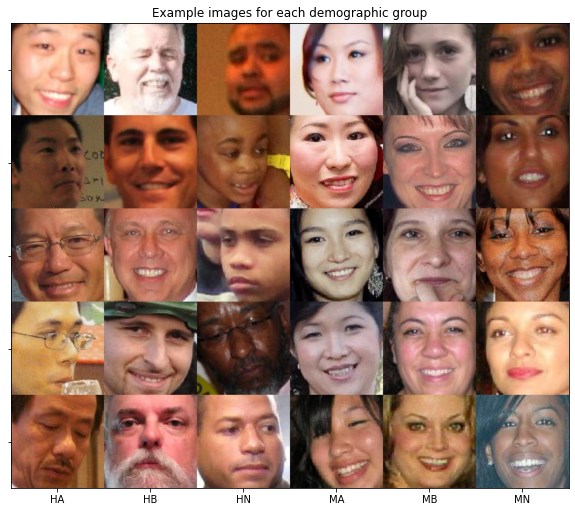

In [ ]:
plot_5_sample(df.sample(200))

---
> As we see the DiveFace dataset (https://github.com/BiDAlab/DiveFace) has an uniform distribution between genders and ethnic origins. It includes ~140K images from ~24K identities.
---








# TASK 1 
### Read the **DiveFace** database and obtain the embeddings of 50 face images (1 image per subject) from the 6 demographic groups (50*6=300 embeddings in total).


## Select 50 face images (1 image per subject) from the 6 demographic groups (50*6=300 images in total).


In [ ]:
# Select 50 face images (1 image per subject) from the 6 demographic groups
df300 = make_dataset(df, end=50)

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 49
--Total images: 300
--Images per Demographic group:
MB    50
HN    50
MN    50
HA    50
HB    50
MA    50
Name: demographic_group, dtype: int64


## Obtain the 300 embeddings from the input images


### Import the ResNet-50 model trained with VGG2 database


In [ ]:
# Import the ResNet-50 model trained with VGG2 database
K.clear_session()
my_model = "resnet50"
resnet = VGGFace(model=my_model)
resnet.summary()

165453824/165439116 [==============================] - 2s 0us/step
Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
________________

### Select the last layer as feature embedding  




In [ ]:
# Select the lat leayer as feature embedding
resnet_clone = clone_model_and_wights(resnet)

last_layer = resnet_clone.get_layer("avg_pool").output
feature_layer = Flatten(name="flatten")(last_layer)
model_vgg = Model(resnet_clone.input, feature_layer)

In [ ]:
# Here we freeze the pre-trained weights to do reuse then in our other classifiers
model_vgg.trainable = False
model_vgg.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
______________________________________________________________________________________________

### Obtain the embeddings

In [ ]:
%%time
imgs, labels = create_input(df300, task="")
embeddings = model_vgg.predict(imgs)
print('embeddings.shape', embeddings.shape)

embeddings.shape (300, 2048)
CPU times: user 15.5 s, sys: 1.08 s, total: 16.5 s
Wall time: 43.2 s


#TASK 2
### Using t-SNE, represent the embeddings and its demographic group. 
Can you differenciate the different demographic groups?

## T-SNE representing the embeddings and its demographic group

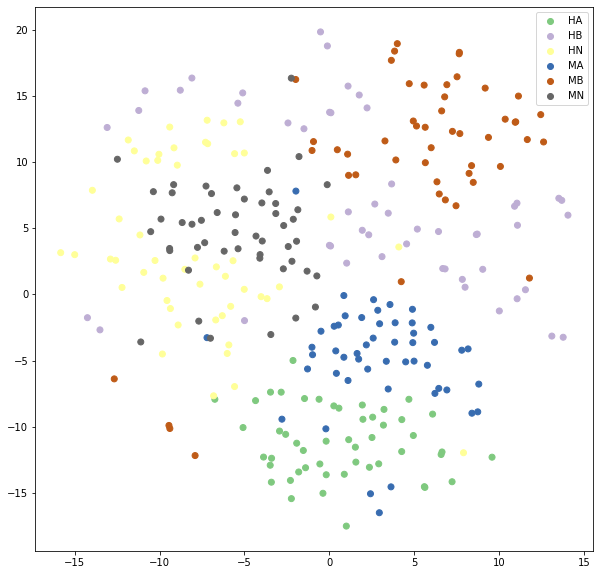

In [ ]:
output_tsne_data = get_tsne(embeddings)
plot_representations(output_tsne_data, labels)


## Can you differenciate the different demographic groups?


### Analysis
---

> Yes. It is clear from the plot that each group is separated from each other. 

> We can see the separation by gender and also by ethnicity. In the image below we used 1000 images for each group instead of 50. It shows in more detail how the six clusters are highly correlated with each demographic group.

> This t-SNE visualuzation projects the 2048D embedding vector of each face into a 2D space. We see how the sensitive **gender and ethnicity** information are highly embedded in the feature space. Using a simple t-SNE algorithm, reducing the feature sapace to only 2 dimensions, reveals the presence of these attributes.

---

> ![]( https://drive.google.com/uc?id=1hcY0fXOvx11MDTU1fX-lytbURw7_Co67)

---




# TASK 3

### Using the ResNet-50 embedding (freeze the model), train your own attribute classifiers (ethnicity and gender). 

*Recommendation: use a simple dense layer with a softmax output. Divide DiveFace into train and test.*

## Train for **ethnicity** using the 300 embeddings

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 49
--Total images: 300
--Images per Demographic group:
MB    50
HN    50
MN    50
HA    50
HB    50
MA    50
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 50
--Last img index for each group: 74
--Total images: 150
--Images per Demographic group:
MB    25
HA    25
HB    25
MA    25
HN    25
MN    25
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered e

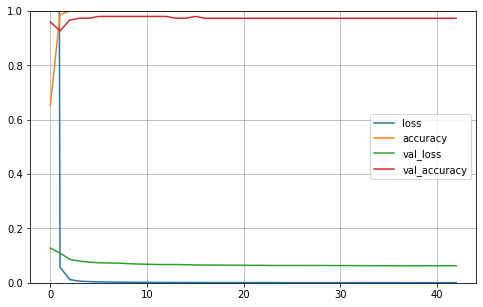

Best epoch: 38 val_loss: 0.06259246915578842

-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
5/5 [==============================] - 0s 79ms/step - loss: 0.1147 - accuracy: 0.9533
Evaluation on test set: [0.11471251398324966, 0.95333331823349]
              precision    recall  f1-score   support

           A       1.00      0.96      0.98        50
           B       0.92      0.96      0.94        50
           N       0.94      0.94      0.94        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



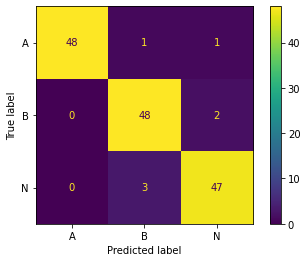

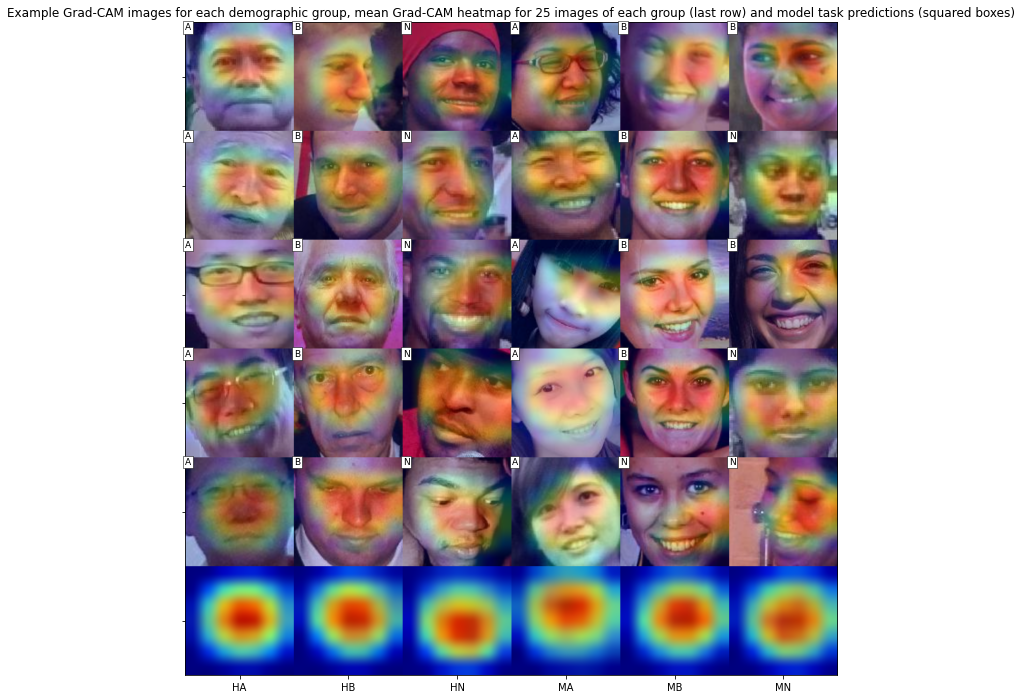

CPU times: user 1min 12s, sys: 2.21 s, total: 1min 14s
Wall time: 2min


In [ ]:
%%time
task_labels = ["A", "B", "N"]

# Get input data
X_train, y_train, X_valid, y_valid, X_test, y_test = make_train_valid_test(
    df, 300, task="ethnicity")
# Train
model_ethnicity_300 = train(X_train, y_train, X_valid, y_valid, model_vgg)
# Evaluate
evaluate(model_ethnicity_300, X_test, y_test, task_labels=task_labels)
# Plot GradCam
plot_grad_cam(model_ethnicity_300, conv_name="activation_48", imgs=X_test, task_labels=task_labels)
# Delete model to free memory 
K.clear_session()
gc.collect()
del model_ethnicity_300

## Train for **gender** using the 300 embeddings

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 49
--Total images: 300
--Images per Demographic group:
MB    50
HN    50
MN    50
HA    50
HB    50
MA    50
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 50
--Last img index for each group: 74
--Total images: 150
--Images per Demographic group:
MB    25
HA    25
HB    25
MA    25
HN    25
MN    25
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered e

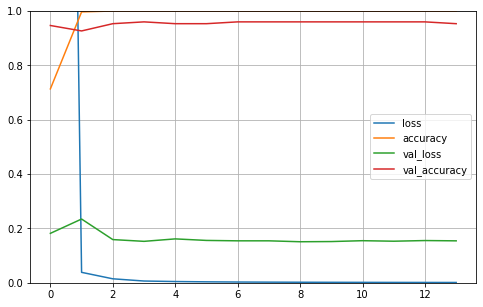

Best epoch: 9 val_loss: 0.15104351937770844

-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
5/5 [==============================] - 0s 82ms/step - loss: 0.0913 - accuracy: 0.9667
Evaluation on test set: [0.09129846841096878, 0.9666666388511658]
              precision    recall  f1-score   support

           H       0.97      0.96      0.97        75
           M       0.96      0.97      0.97        75

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



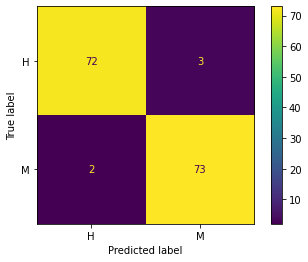

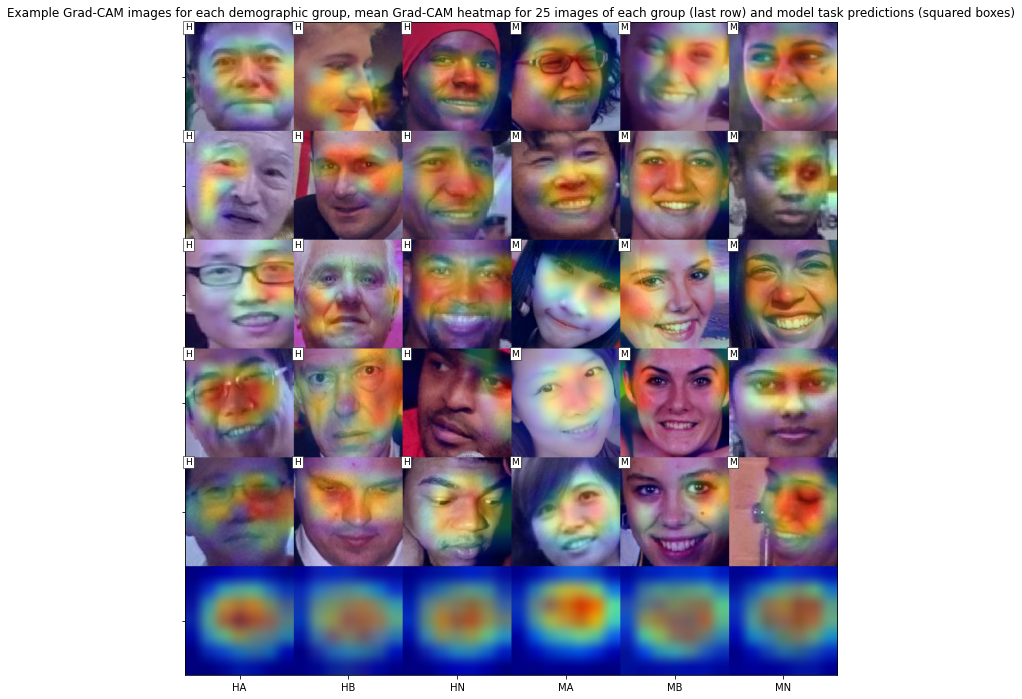

CPU times: user 43.2 s, sys: 1.01 s, total: 44.2 s
Wall time: 1min 12s


In [ ]:
%%time
task_labels=['H', 'M']

# Get input data
X_train, y_train, X_valid, y_valid, X_test, y_test = make_train_valid_test(df, 300, task='gender')
# Train
model_gender_300 = train(X_train, y_train, X_valid, y_valid,model_vgg)
# Evaluate
evaluate(model_gender_300, X_test, y_test, task_labels=task_labels)
# Plot GradCam
plot_grad_cam(model_gender_300, conv_name="activation_48", imgs=X_test, task_labels=task_labels)
# Delete model to free memory 
K.clear_session()
gc.collect()
del model_gender_300

## Analysis


---
> The results of the two models (gender and ethnicity) confirm what we saw before in the T-SNE plot. The sensitive information so is embedded in the feature space that just adding a dense layer with 1024 units and a softmax output layer we can train very accurate models (> 95% accuracy) for each task.

> On the results from the models, we can see the Confusion Matrix that shows that the models have only few mistakes.

> To see how the response of the models vary from one person to another we use the Grad-CAM visualization techinique wich uses the gradients of a target flowing into a selected convolutional layer (in this case we use the last layer) to produce a coarse localization map. The superimposed images and heatmaps reveals for each person which region is most activated for the task. We see that the central face region (between eyes, nose, and mouth) is the most activated region and the averaged heatmaps for 25 images of each group show confirm this hypothesis. It is interesting to note, as we trained the model with a balanced dataset, the averaged heatmaps have similar intensity for all groups and the performance of the model does not differ much for each group. 

> Later we are going to see how these values change as we train our model with biased datasets. 
---




# TASK 4.1
Train 3 different Gender Classifiers (previous Task 3.3) using images from same ethnic group: Model A (only Asian), Model B (only Black), Model C (only Caucasian)


## Model A: 1000 images from Asian group 

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 499
--Total images: 1000
--Images per Demographic group:
HA    500
MA    500
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A']
--Images per Subject: 1
--First img index for each group: 500
--Last img index for each group: 749
--Total images: 500
--Images per Demographic group:
HA    250
MA    250
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A']
--Images per Subject: 1
--First img index for each group: 750
--La

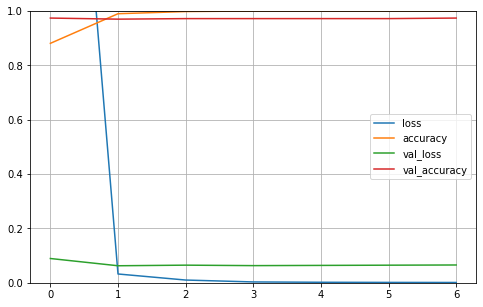

Best epoch: 2 val_loss: 0.06269657611846924


In [ ]:
# Get input data
X_train_A, y_train_A, X_valid_A, y_valid_A, X_test_A, y_test_A = make_train_valid_test(
    df, 1000, ethnicity=['A'] ,task='gender'
)
# Train
model_gender_A = train(X_train_A, y_train_A, X_valid_A, y_valid_A, model_vgg)

## Model B: 1000 images from Black group 

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['N']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 499
--Total images: 1000
--Images per Demographic group:
MN    500
HN    500
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['N']
--Images per Subject: 1
--First img index for each group: 500
--Last img index for each group: 749
--Total images: 500
--Images per Demographic group:
HN    250
MN    250
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['N']
--Images per Subject: 1
--First img index for each group: 750
--La

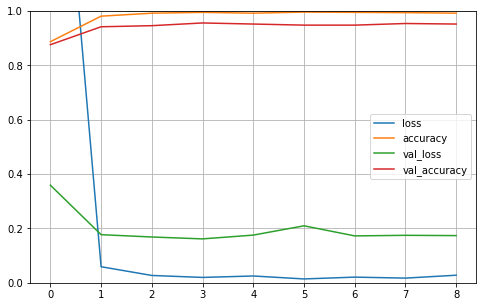

Best epoch: 4 val_loss: 0.16156917810440063
CPU times: user 33.2 s, sys: 2.26 s, total: 35.5 s
Wall time: 52.2 s


In [ ]:
%%time
# Get input data
X_train_B, y_train_B, X_valid_B, y_valid_B, X_test_B, y_test_B = make_train_valid_test(
    df, 1000, ethnicity=['N'] ,task='gender'
)
# Train
model_gender_B = train(X_train_B, y_train_B, X_valid_B, y_valid_B, model_vgg)

## Model C: 1000 images from Caucasian group 

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['B']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 499
--Total images: 1000
--Images per Demographic group:
HB    500
MB    500
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['B']
--Images per Subject: 1
--First img index for each group: 500
--Last img index for each group: 749
--Total images: 500
--Images per Demographic group:
MB    250
HB    250
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['B']
--Images per Subject: 1
--First img index for each group: 750
--La

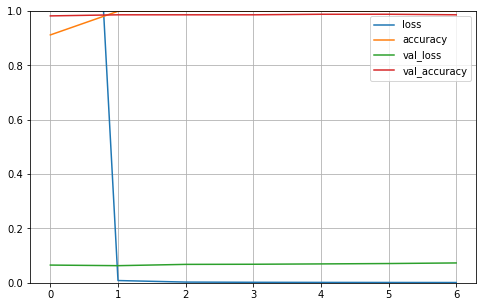

Best epoch: 2 val_loss: 0.06302426755428314
CPU times: user 28.7 s, sys: 2.03 s, total: 30.7 s
Wall time: 52.8 s


In [ ]:
%%time
# Get input data
X_train_C, y_train_C, X_valid_C, y_valid_C, X_test_C, y_test_C = make_train_valid_test(
    df, 1000, ethnicity=['B'] ,task='gender'
)
# Train
model_gender_C = train(X_train_C, y_train_C, X_valid_C, y_valid_C, model_vgg)

# TASK 4.2
Evaluate the 3 Gender Classifiers (previous Task 4.1) using images from each of the three ethnic groups.

## 1) Model A -> test A


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 85ms/step - loss: 0.0492 - accuracy: 0.9760
Evaluation on test set: [0.04922804608941078, 0.9760000109672546]
              precision    recall  f1-score   support

           H       0.96      0.99      0.98       250
           M       0.99      0.96      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



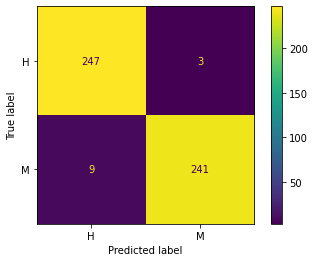

In [ ]:
evaluate(model_gender_A, X_test_A, y_test_A, task_labels=['H', 'M'])

## 2) Model A -> test B


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 83ms/step - loss: 0.2510 - accuracy: 0.9200
Evaluation on test set: [0.25099146366119385, 0.9200000166893005]
              precision    recall  f1-score   support

           H       0.90      0.94      0.92       250
           M       0.94      0.90      0.92       250

    accuracy                           0.92       500
   macro avg       0.92      0.92      0.92       500
weighted avg       0.92      0.92      0.92       500



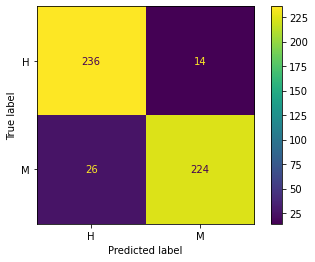

In [ ]:
evaluate(model_gender_A, X_test_B, y_test_B, task_labels=['H', 'M'])

## 3) Model A -> test C


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 83ms/step - loss: 0.4031 - accuracy: 0.8460
Evaluation on test set: [0.40310582518577576, 0.8460000157356262]
              precision    recall  f1-score   support

           H       0.87      0.82      0.84       250
           M       0.83      0.88      0.85       250

    accuracy                           0.85       500
   macro avg       0.85      0.85      0.85       500
weighted avg       0.85      0.85      0.85       500



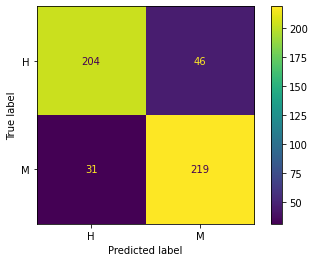

In [ ]:
evaluate(model_gender_A, X_test_C, y_test_C, task_labels=['H', 'M'])

## 4) Model B -> test A


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 83ms/step - loss: 0.1236 - accuracy: 0.9520
Evaluation on test set: [0.12359552085399628, 0.9520000219345093]
              precision    recall  f1-score   support

           H       0.95      0.96      0.95       250
           M       0.96      0.95      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500



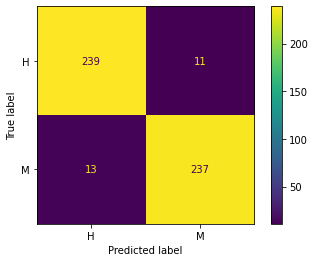

In [ ]:
evaluate(model_gender_B, X_test_A, y_test_A, task_labels=['H', 'M'])

## 5) Model B -> test B


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 84ms/step - loss: 0.1662 - accuracy: 0.9560
Evaluation on test set: [0.16621044278144836, 0.9559999704360962]
              precision    recall  f1-score   support

           H       0.95      0.97      0.96       250
           M       0.97      0.94      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



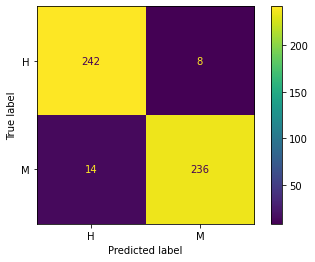

In [ ]:
evaluate(model_gender_B, X_test_B, y_test_B, task_labels=['H', 'M'])

## 6) Model B -> test C


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 85ms/step - loss: 0.1714 - accuracy: 0.9340
Evaluation on test set: [0.17141801118850708, 0.9340000152587891]
              precision    recall  f1-score   support

           H       0.93      0.94      0.93       250
           M       0.94      0.93      0.93       250

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



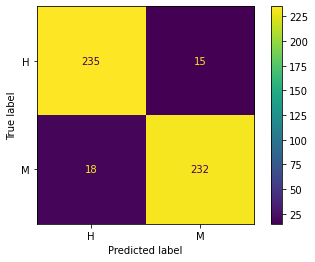

In [ ]:
evaluate(model_gender_B, X_test_C, y_test_C, task_labels=['H', 'M'])

## 7) Model C -> test A


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 84ms/step - loss: 0.2838 - accuracy: 0.8740
Evaluation on test set: [0.2837945520877838, 0.8740000128746033]
              precision    recall  f1-score   support

           H       0.84      0.92      0.88       250
           M       0.91      0.83      0.87       250

    accuracy                           0.87       500
   macro avg       0.88      0.87      0.87       500
weighted avg       0.88      0.87      0.87       500



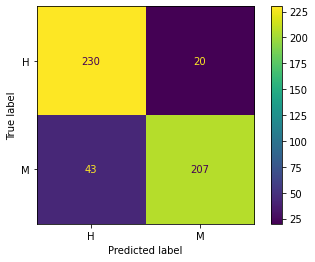

In [ ]:
evaluate(model_gender_C, X_test_A, y_test_A, task_labels=['H', 'M'])

## 8) Model C -> test B


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 85ms/step - loss: 0.2516 - accuracy: 0.9020
Evaluation on test set: [0.25157177448272705, 0.9020000100135803]
              precision    recall  f1-score   support

           H       0.86      0.96      0.91       250
           M       0.96      0.84      0.90       250

    accuracy                           0.90       500
   macro avg       0.91      0.90      0.90       500
weighted avg       0.91      0.90      0.90       500



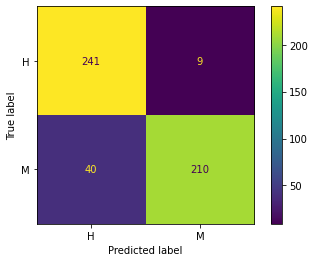

In [ ]:
evaluate(model_gender_C, X_test_B, y_test_B, task_labels=['H', 'M'])

## 9) Model C -> test C


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 84ms/step - loss: 0.0356 - accuracy: 0.9860
Evaluation on test set: [0.03563022240996361, 0.9860000014305115]
              precision    recall  f1-score   support

           H       0.99      0.98      0.99       250
           M       0.98      0.99      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



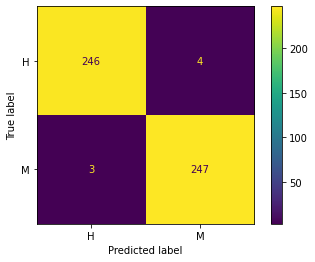

In [ ]:
evaluate(model_gender_C, X_test_C, y_test_C, task_labels=['H', 'M'])

## Analysis


---
> Evaluating the results for this task we see how a biased dataset can affect the performance of our model when evaluating on targets that weren't in our training data. 

> 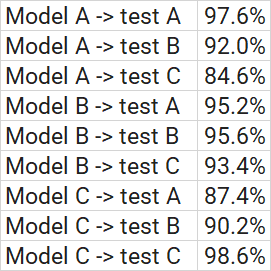


> We see from the table above that when we train and test using the same group the accuracy is very high but when we test on another group the performance drops considerably, more than 10% in some cases (model A and C). 

> These results show that the models are using features that are not explicity meant to be used for the training. In this case, the models are using the skin color implicitly as an important feature to the gender classification task. It shows how important deeply analyse our data and how our models are being trained to build fairer algorithms. 

> In https://arxiv.org/pdf/2004.11246.pdf they propose a discrimination-aware learning method that improves performance in terms of average accuracy and fairness of a face recognition system. 
---

# TASK 4.3
Train one Gender Classifiers (previous Task 3.3) using images from all three ethnic groups



## Model D: 1000 images from Asian group + 1000 images from Black group + 1000 images from Caucasian group 

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'N', 'B']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 499
--Total images: 3000
--Images per Demographic group:
HN    500
MN    500
HA    500
MA    500
HB    500
MB    500
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'N', 'B']
--Images per Subject: 1
--First img index for each group: 500
--Last img index for each group: 749
--Total images: 1500
--Images per Demographic group:
HN    250
HB    250
MN    250
HA    250
MB    250
MA    250
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 

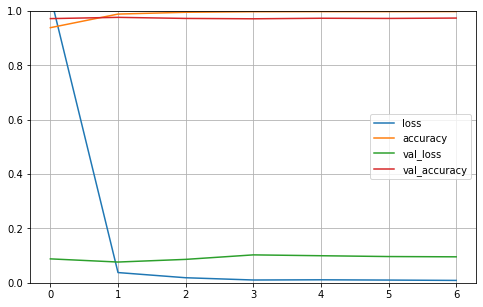

Best epoch: 2 val_loss: 0.07638676464557648
CPU times: user 1min 1s, sys: 13.4 s, total: 1min 14s
Wall time: 1min 55s


In [ ]:
%%time
# Get input data
X_train_D, y_train_D, X_valid_D, y_valid_D, X_test_D, y_test_D = make_train_valid_test(
    df, 3000, ethnicity=['A', 'N', 'B'] ,task='gender'
)
# Train
model_gender_D = train(X_train_D, y_train_D, X_valid_D, y_valid_D, model_vgg)

# TASK 4.4
Evaluate the Gender Classifier (previous Task 4.3) using images from each of the three ethnic groups


## 10) Model D -> test A


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 83ms/step - loss: 0.0349 - accuracy: 0.9920
Evaluation on test set: [0.03490647301077843, 0.9919999837875366]
              precision    recall  f1-score   support

           H       0.99      1.00      0.99       250
           M       1.00      0.99      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



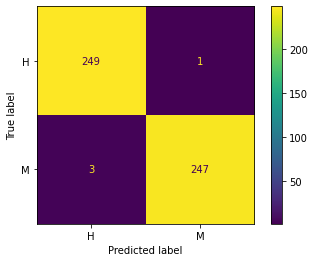

In [ ]:
evaluate(model_gender_D, X_test_A, y_test_A, task_labels=['H', 'M'])

## 11) Model D -> test B


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 83ms/step - loss: 0.1302 - accuracy: 0.9600
Evaluation on test set: [0.13023707270622253, 0.9599999785423279]
              precision    recall  f1-score   support

           H       0.95      0.98      0.96       250
           M       0.98      0.94      0.96       250

    accuracy                           0.96       500
   macro avg       0.96      0.96      0.96       500
weighted avg       0.96      0.96      0.96       500



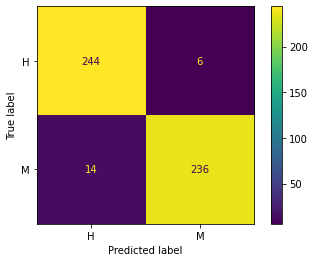

In [ ]:
evaluate(model_gender_D, X_test_B, y_test_B, task_labels=['H', 'M'])

## 12) Model D -> test C


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
16/16 [==============================] - 1s 84ms/step - loss: 0.0457 - accuracy: 0.9820
Evaluation on test set: [0.04565676674246788, 0.9819999933242798]
              precision    recall  f1-score   support

           H       0.98      0.98      0.98       250
           M       0.98      0.98      0.98       250

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



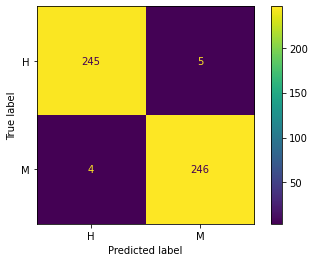

In [ ]:
evaluate(model_gender_D, X_test_C, y_test_C, task_labels=['H', 'M'])

## 13) Model D -> test D


-----------------------------------------------------------------
Evaluating...
-----------------------------------------------------------------
47/47 [==============================] - 4s 85ms/step - loss: 0.0703 - accuracy: 0.9780
Evaluation on test set: [0.07026676088571548, 0.9779999852180481]
              precision    recall  f1-score   support

           H       0.97      0.98      0.98       750
           M       0.98      0.97      0.98       750

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



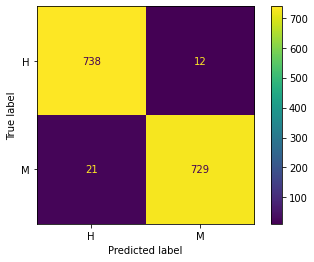

In [ ]:
evaluate(model_gender_D, X_test_D, y_test_D, task_labels=['H', 'M'])

## Analysis


---
> In this task evaluate the model D, trained with a balanced dataset with 1000 images of each demographic group. 

> 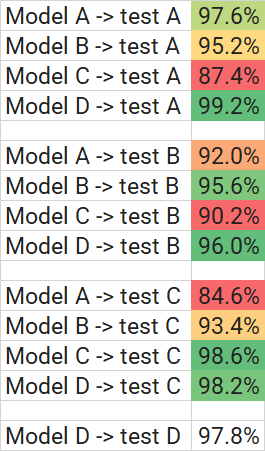

> The table above shows how the accuracy and fairness increase when we use the balanced dataset. 


---



## Delete datasets from memory

In [ ]:
del X_train_A 
del X_train_B 
del X_train_C

del X_valid_A 
del X_valid_B 
del X_valid_C

del X_test_A 
del X_test_B 
del X_test_C 

del y_train_A 
del y_train_B 
del y_train_C

del y_valid_A 
del y_valid_B 
del y_valid_C

del y_test_A 
del y_test_B 
del y_test_C

gc.collect()

0

# TASK 4.5 - GradCam

For graCam read this paper: 
https://arxiv.org/pdf/2004.11246.pdf

## Model A

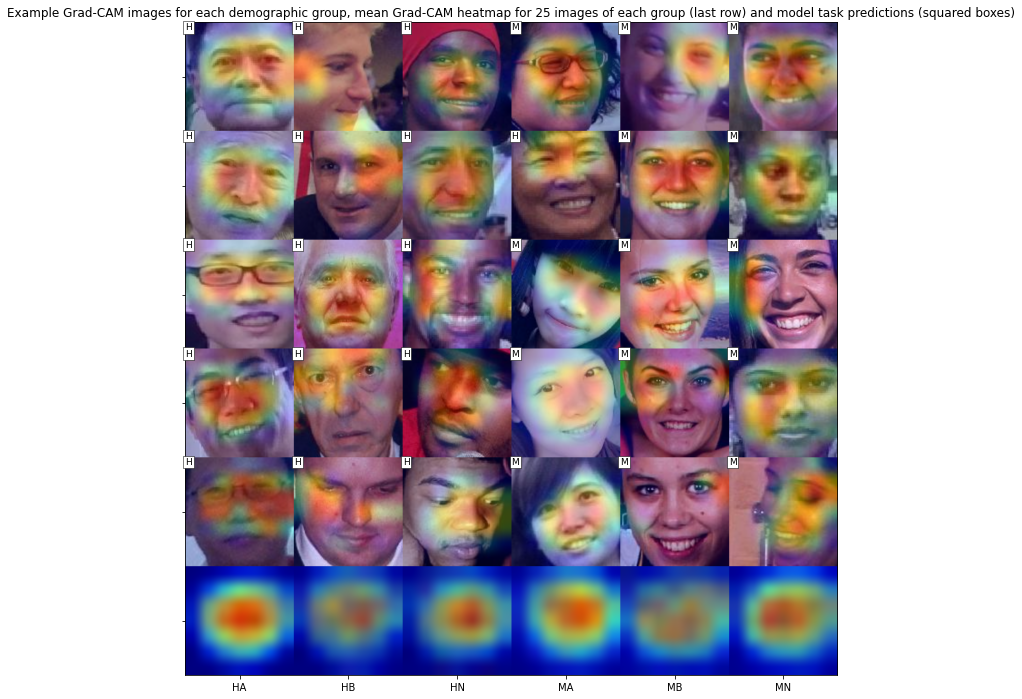

CPU times: user 16.1 s, sys: 81.5 ms, total: 16.2 s
Wall time: 16.2 s


In [ ]:
%%time
plot_grad_cam(model_gender_A, conv_name="activation_48", imgs=X_test, task_labels=['H', 'M'])

### Delete model A to free memory

In [ ]:
# Delete model to free memory 
K.clear_session()
gc.collect()
del model_gender_A

## Model B

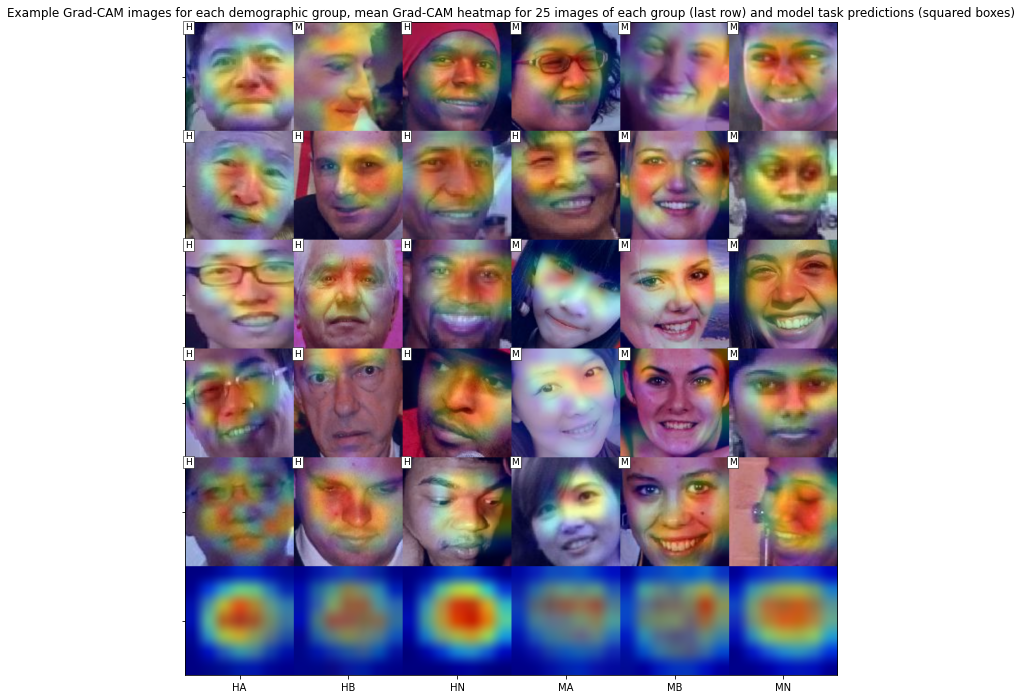

CPU times: user 16.3 s, sys: 87.7 ms, total: 16.4 s
Wall time: 16.5 s


In [ ]:
%%time
plot_grad_cam(model_gender_B, conv_name="activation_48", imgs=X_test, task_labels=['H', 'M'])

### Delete model B to free memory

In [ ]:
# Delete model to free memory 
K.clear_session()
gc.collect()
del model_gender_B

## Model C

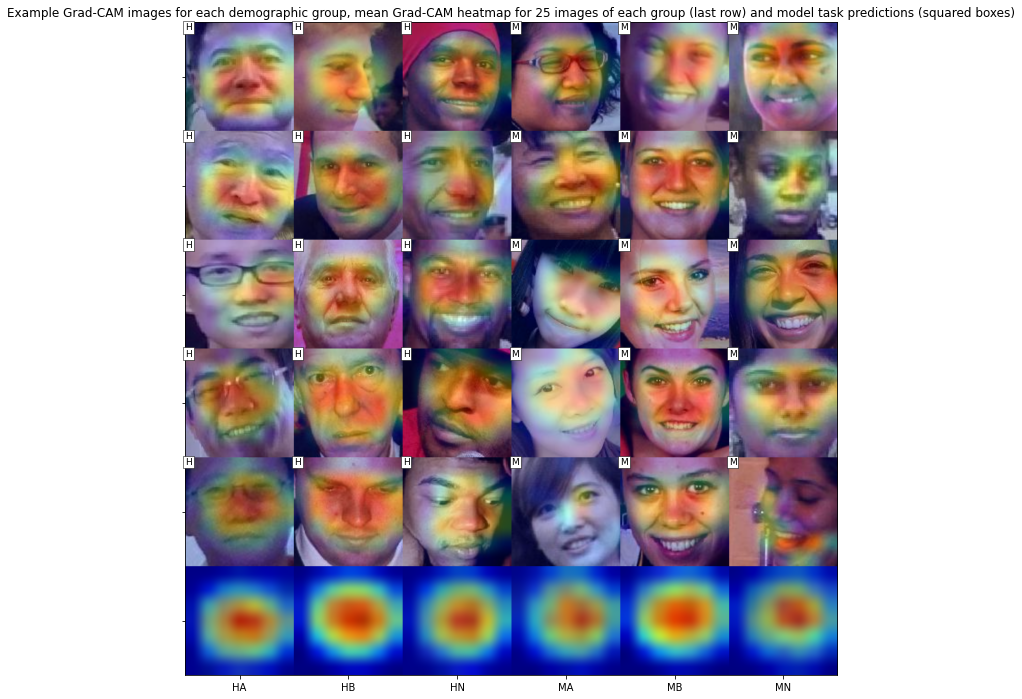

CPU times: user 16.5 s, sys: 72.3 ms, total: 16.6 s
Wall time: 16.5 s


In [ ]:
%%time
plot_grad_cam(model_gender_C, conv_name="activation_48", imgs=X_test, task_labels=['H', 'M'])

### Delete model C to free memory

In [ ]:
# Delete model to free memory 
K.clear_session()
gc.collect()
del model_gender_C

## Model D

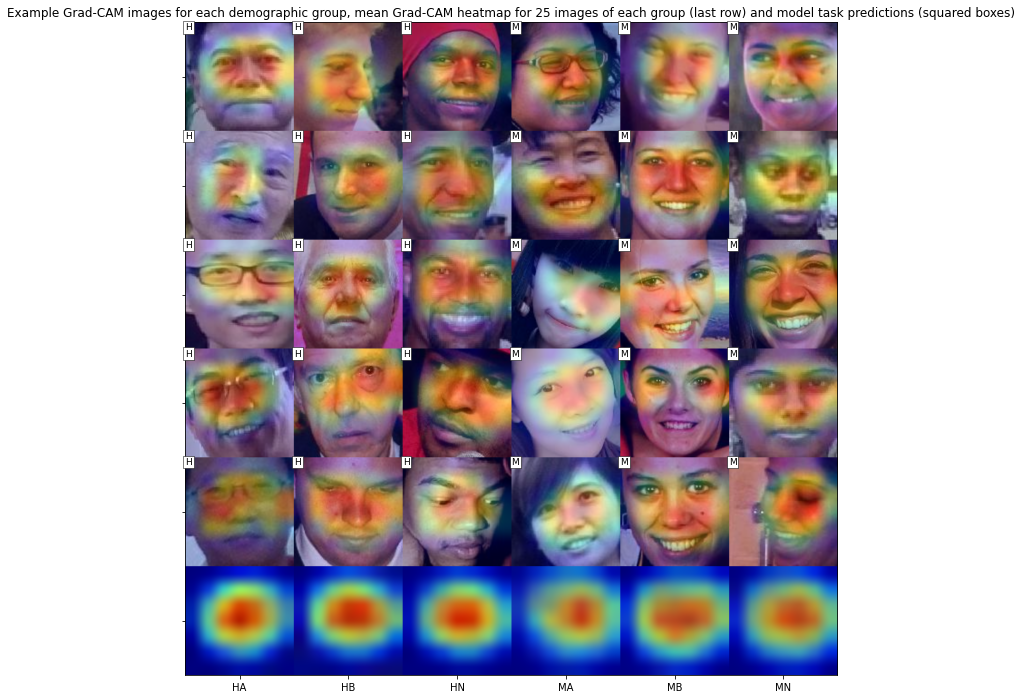

CPU times: user 16.4 s, sys: 87.7 ms, total: 16.5 s
Wall time: 16.6 s


In [ ]:
%%time
plot_grad_cam(model_gender_D, conv_name="activation_48", imgs=X_test, task_labels=['H', 'M'])

## Analysis
---

> In this task we see how the activation maps change for each image when using the different trained models. The most interesting to note is that when using the biased models, the heatmap intensity is much higher for the class the model was trained with while when using the fair dataset they have similar intensity. 

---

# Task 5 - Looking at Learned Feature Spaces

n_outputs: 2

-----------------------------------------------------------------
Training...
-----------------------------------------------------------------
X_train.shape (3000, 224, 224, 3)
y_train.shape (3000,)


Epoch 1/50
94/94 [==============================] - 24s 166ms/step - loss: 2.8856 - accuracy: 0.7648 - val_loss: 0.1109 - val_accuracy: 0.9647
Epoch 2/50
94/94 [==============================] - 12s 130ms/step - loss: 0.0477 - accuracy: 0.9850 - val_loss: 0.1666 - val_accuracy: 0.9460
Epoch 3/50
94/94 [==============================] - 12s 129ms/step - loss: 0.0196 - accuracy: 0.9948 - val_loss: 0.0826 - val_accuracy: 0.9733
Epoch 4/50
94/94 [==============================] - 12s 126ms/step - loss: 0.0110 - accuracy: 0.9976 - val_loss: 0.0954 - val_accuracy: 0.9720
Epoch 5/50
94/94 [==============================] - 12s 125ms/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0998 - val_accuracy: 0.9720
Epoch 6/50
94/94 [==============================] - 12s 125ms/step - 

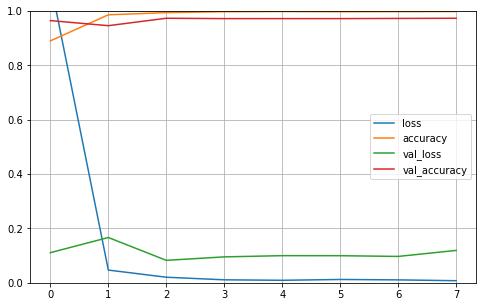

Best epoch: 3 val_loss: 0.0825783833861351


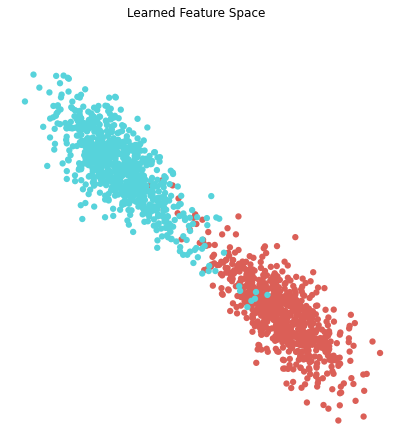

In [ ]:
model_gender_D_2D = train(X_train_D, y_train_D, X_valid_D, y_valid_D, model_vgg, True)

#Select the layer with two units
embedding_layer = model_gender_D_2D.get_layer("feature_layer").output            
feature_extractor = Model(model_gender_D_2D.input, embedding_layer)
        
    
#Plot the feature embedding
trained_model=feature_extractor    
X_train_trm = trained_model.predict(X_test_D)
scatter(X_train_trm, y_test_D, "Learned Feature Space - gender", 2) 

-----------------------------------------------------------------
Creating input data...
-----------------------------------------------------------------

----------TRAIN----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 0
--Last img index for each group: 499
--Total images: 3000
--Images per Demographic group:
HN    500
MN    500
HA    500
MA    500
HB    500
MB    500
Name: demographic_group, dtype: int64

----------VALID----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 'M']
--Filtered ethnicities: ['A', 'B', 'N']
--Images per Subject: 1
--First img index for each group: 500
--Last img index for each group: 749
--Total images: 1500
--Images per Demographic group:
HN    250
HB    250
MN    250
HA    250
MB    250
MA    250
Name: demographic_group, dtype: int64

----------TEST----------

Filtering Datasets...
----INFO:
--Filtered genders: ['H', 

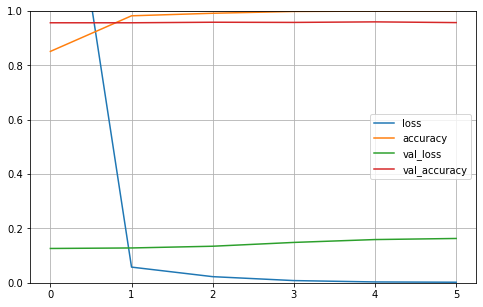

Best epoch: 1 val_loss: 0.1262795776128769


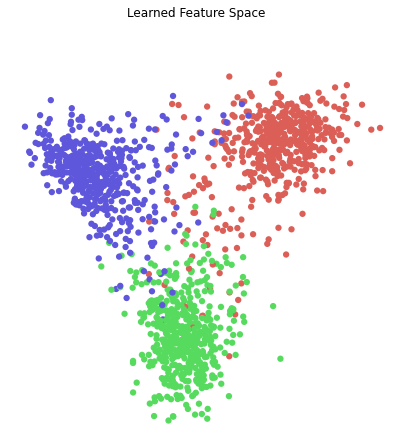

In [ ]:

# Get input data
X_train_D, y_train_D, X_valid_D, y_valid_D, X_test_D, y_test_D = make_train_valid_test(
    df, 3000, task='ethnicity'
)

model_ethnicity_D_2D = train(X_train_D, y_train_D, X_valid_D, y_valid_D, model_vgg, True)

#Select the layer with two units
embedding_layer = model_ethnicity_D_2D.get_layer("feature_layer").output            
feature_extractor = Model(model_ethnicity_D_2D.input, embedding_layer)
        
    
#Plot the feature embedding
trained_model=feature_extractor    
X_train_trm = trained_model.predict(X_test_D)
scatter(X_train_trm, y_test_D, "Learned Feature Space - ethnicity", 3) 

## Analysis
---

> In this task the goal is to viasualize the feature space generated by the loss function in 2D dimension. Differently from the t-SNE this is a supervised method where in add a 2-unit layer just before the output layer like the image below. 
> ![]( https://drive.google.com/uc?id=1z_myXSpAjgexq3PLbb4-ICaa01qO3cDQ)

> This visualization is useful because depending on our problem is better to chose on loss function or another. For example, the expected 2D feature space plots for the Softmax, Center Loss and Triplet Loss are represented in the image below. Softmax is one of the most common loss function choices but for example if we want to maximize the inter-class distance, we should use the center or the triplet loss. 

![]( https://drive.google.com/uc?id=1Z2R4YhkHr9a38B4nqom73onLvI_pZ05f)

> In this work we used the softmax for the gender and ethinicity classigication tasks and we see that the 2D feature space is how we expected. 
---


In [ ]:
end = time.time()
print("ENTIRE NOTEBOOK EXECUTION TIME:", round((end-start)/60, 2), "min")

ENTIRE NOTEBOOK EXECUTION TIME: 15.94 min
